# __TITLE TK__
## Using Neural Networks to and Reddit Comments to Predict Movie Ratings

Flatiron School Data Science: Capstone Project

- **Author**: Zaid Shoorbajee
- **Instructor**: Morgan Jones
- **Pace**: Flex, 40 weeks

# **IMAGE TK TK TK**

## Business Understanding <a name="biz"></a>

A movie studio, Cinedistance, wants to know how well its movies will be received by audiences before it releases them. After all the hard work of producing a big-budget movie, there are still many decisions about the marketing and release of the movie. How much should the studio invest in marketing? Should it release it to a streaming or theaters? To make these decisions, it's helpful to know how much audiences will actually like the movie first.

Cinedistance wants to get qualitative comments from average moviegoers *before* a movie's official release. It is also employing a data scientist to use these comments to predict a rating for the movie, like an IMDb score. It's piloting a program where the movie is released to a focus group of about 100 average moviegoers. These viewers are asked to sign an NDA, watch the movie, and submit their thoughts about the movie as if they are commenting on an internet comment section.

The task of the data scientist is to apply natural language processing (NLP) and machine learning (ML) to the focus group's comments in order to predict a movie's IMDb score. These qualitative comments and predicted score can inform Cinedistance's decision-making about the movie's marketing, release. The studio may decide to do re-shoots, re-edits, or even [kill the movie](https://variety.com/2022/film/news/batgirl-not-released-warner-bros-hbo-max-1235331897/).

<!-- An international news outlet, *The Flatiron Post*, wants to be able to report on stories of crises and natural disasters in a prompt manner. News about plane crashes, hurricanes, earthquakes, terrorist threats, and other topics occurs without warning. Being late to the story can mean not only losing to the competition, but also leaving your audience in the dark while speculation runs amok. 

The *Post* wants to tap into Twitter as a resource in order to detect such disasters in real time, and it’s employing a data scientist for the task. Twitter is a fire hose of information; there is a lot more noise than signal, and reporters would waste a lot of time staring at their Twitter feeds just waiting for disaster tweets. But chances are that if a disaster is occurring, someone is tweeting about it. 

The task of the data scientist is to use natural language processing (NLP) and machine learning in order to systematically tell if a tweet is about a real disaster or not. Such tweets can then theoretically be presented to the newsroom in a separate feed. Reporters can then choose to pursue that story or not. -->

## Data Understanding <a name="data_understanding"></a>

### Dataset <a name="dataset"></a>

Movie fans do do the type of commentary that Cinedistance is looking for everyday in places like the [Reddit community r/movies](reddit.com/r/movies). On **r/movies**, Reddit users share news and opinions about movies. Additionally, for most major movies that come out, the subreddit hosts an official discussion of the movie. These official discussions contains text data that can be the basis to train an ML model to predict IMDb scores.

Reddit has an API that allows developers to scrape such information. The [PRAW library](https://praw.readthedocs.io/) simplifies this, acting as a wrapper for the API. Using PRAW, I scraped from r/movies the **highest-voted 100 comments of as many official movie discussions still indexed on Reddit**. Some discussions had fewer than 100 comments. I also downloaded [freely available ratings  data from IMDb](https://www.imdb.com/interfaces/) and matched scores to r/movies discussions.

 The resulting dataset contains:
* 922 movies
* 70,693 comments
* Movie title
* Reddit post ID and IMDB ID
* Reddit discussion date
* IMDb average rating **(target variable)**
* Number of IMDb votes
* Movie runtimes
* Genres

### NLP <a name="nlp"></a>

The core type of data being used for this task is the text of Reddit comments. This is **unstructured data** and requires natural language processing (NLP) techniques in order to be interpretable by a machine learning model, such as a deep neural network. 

Working with natural language is messy; different comments can have many of the same words, but context changes everything. It's easy for people to discern the difference, but for a computer, it's not so simple. To make comments interpretable by a neural network, this project uses the following NLP techniques:

* Tokenization
* Lemmatization
* Removing stop words
* TF-IDF Vectorization
* Part-of-speech tagging
* Sentiment analysis
* Meta-feature extraction

The idea is that converting comments into the signals listed above should help a machine learning model to discern a relationship between the comments and IMDb scores using hidden patterns.

## Modeling

This project ultimately is a regression task. I will be using [TensorFlow through the Keras interface](https://www.tensorflow.org/api_docs/python/tf/keras) in order to build a deep neural network. The neural network will be trained on a preprocessed version of the r/movies dataset that I have built.

## Scoring and Evaluation

The business case that a movie studio wants to know the IMDb rating of a move before it is released. The IMDb scores the models are trained on have a degree of variability that can't be accounted for 100% of the time with predictions. The R-squared score tells us what percent of the variability of the target variable the model accounts for, so R-squared will be reported to the stakeholder.

Models in this notebook will also report the mean squared error (MSE), which is a measure of average distance of predictions from the true target values. Minimizing MSE is what the models will be optimizing for.

In [1]:
import time
start_time = time.time()
def time_check(start=None):
    if start:
        t = time.time() - start
    else:
        t = time.time() - start_time
    print(f'Time check: {t//60:.0f} minutes and {t%60:.0f} seconds')

In [2]:
# Imports

import numpy as np
import pandas as pd
import warnings
import datetime

from nltk import FreqDist
from nltk.corpus import stopwords
import spacy
from spacy import displacy

from scipy.stats import pearsonr, spearmanr, kendalltau

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression

from tensorflow.keras import models, layers, regularizers
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.random import set_seed
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow_addons.metrics import RSquare

import re
from collections import OrderedDict
import itertools
import string
from math import trunc

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
%matplotlib inline

import praw

import json

pd.options.display.max_colwidth = 100
pd.options.display.max_rows = 100
seed = 55
np.random.seed(seed)

## Data Preparation

The dataset used in this notebook was compiled by me in several other notebooks. See the [compile_and_filter_dataset](./compile_and_filter_dataset/) folder in this repository for the detailed process of how the data was collected.

### Read in final dataset, containing reddit comments and IMDb scores.

In [3]:
df = pd.read_csv('./data/data_final.csv')

In [4]:
df.head()

,id,tconst,title,originalTitle,comments,runtimeMinutes,startYear,post_date_utc,post_year,post_month,post_day,genres,numVotes,averageRating
0,vzcwal,tt13406136,the princess,The Princess,Joey King needs a new agent. She’s proven she has talent but she has so many terrible films on h...,94.0,2022,1.657851e+09,2022,7,14,"Action,Drama,Fantasy",11474,5.6
1,vzcwal,tt13406136,the princess,The Princess,"Silly, but entertaining and non stop action",94.0,2022,1.657851e+09,2022,7,14,"Action,Drama,Fantasy",11474,5.6
2,vzcwal,tt13406136,the princess,The Princess,"The yassification of The Raid\n\nActually, this was fun enough and mad respect to Joey King for ...",94.0,2022,1.657851e+09,2022,7,14,"Action,Drama,Fantasy",11474,5.6
3,vzcwal,tt13406136,the princess,The Princess,"Honestly, this was pretty fun. The plot is nothing special yes.\n\nBut Joey King was actually e...",94.0,2022,1.657851e+09,2022,7,14,"Action,Drama,Fantasy",11474,5.6
4,vzcwal,tt13406136,the princess,The Princess,"Man, I loved this movie. Yeah, it was campy, but whatever. The premise worked for me, I liked th...",94.0,2022,1.657851e+09,2022,7,14,"Action,Drama,Fantasy",11474,5.6


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70692 entries, 0 to 70691
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   id              70692 non-null  object 
 1   tconst          70692 non-null  object 
 2   title           70692 non-null  object 
 3   originalTitle   70692 non-null  object 
 4   comments        70692 non-null  object 
 5   runtimeMinutes  70692 non-null  float64
 6   startYear       70692 non-null  int64  
 7   post_date_utc   70692 non-null  float64
 8   post_year       70692 non-null  int64  
 9   post_month      70692 non-null  int64  
 10  post_day        70692 non-null  int64  
 11  genres          70621 non-null  object 
 12  numVotes        70692 non-null  int64  
 13  averageRating   70692 non-null  float64
dtypes: float64(3), int64(5), object(6)
memory usage: 7.6+ MB


### "Imploding" the dataframe

Currently, each comment is its own row, giving the dataset over 70,000 rows.

In reality, each of these comments corresponds to one of about 900 movies.

That's how I'm going to be dealing with this data from now own, so I will compress all the comments into lists.

In [6]:
comments_imploded = df.groupby('id')['comments'].agg(list)

In [7]:
df = df.drop_duplicates(subset='id').drop(columns=['comments'])
df = df.join(comments_imploded, on='id')
df['n_comments'] = df['comments'].apply(len)
df.head()

,id,tconst,title,originalTitle,runtimeMinutes,startYear,post_date_utc,post_year,post_month,post_day,genres,numVotes,averageRating,comments,n_comments
0,vzcwal,tt13406136,the princess,The Princess,94.0,2022,1.657851e+09,2022,7,14,"Action,Drama,Fantasy",11474,5.6,[Joey King needs a new agent. She’s proven she has talent but she has so many terrible films on ...,21
21,vzcw0a,tt11671006,the man from toronto,The Man from Toronto,110.0,2022,1.657851e+09,2022,7,14,"Action,Adventure,Comedy",43386,5.8,[ O offence to Woody but I feel like the original casting of Jason Statham would have at least i...,23
44,vzcvsd,tt9288046,the sea beast,The Sea Beast,115.0,2022,1.657851e+09,2022,7,14,"Adventure,Animation,Comedy",35834,7.1,[Absolutely crazy that Netflix dropped this and also The Mitchells Vs The Machines with almost n...,77
121,vzcvkz,tt5151570,mrs harris goes to paris,Mrs. Harris Goes to Paris,115.0,2022,1.657851e+09,2022,7,14,"Comedy,Drama",4798,7.1,"[This was so cute it just made me smile the whole time. Highly recommend., The only word for th...",22
143,vzcv66,tt9411972,where the crawdads sing,Where the Crawdads Sing,125.0,2022,1.657851e+09,2022,7,14,"Drama,Mystery,Thriller",28694,7.1,[I did enjoy her house representing the 2 different ways the men treated her . Tate was invited ...,93


Reducing the dataset to only *potentially* relevant features, although I may not use all.

In [8]:
df = df[[
    'id', 'tconst', 'title', 'averageRating', 'numVotes',
    'runtimeMinutes', 'genres', 'comments', 'n_comments'
    ]]

#### Missing Values

In [9]:
df.isna().sum()

id                0
tconst            0
title             0
averageRating     0
numVotes          0
runtimeMinutes    0
genres            1
comments          0
n_comments        0
dtype: int64

The only feature with a missing values is `genre`.

In [10]:
df[df['genres'].isna()]

,id,tconst,title,averageRating,numVotes,runtimeMinutes,genres,comments,n_comments
2378,t0tapr,tt15374070,studio 666,5.7,7356,106.0,NaN,"[Scooby Foo, As “okay” as the film is, the chainsaw double kill was absolutely gnarly., There’s ...",71


I'm not sure why this wasn't in the dataset, but on IMDb's website, this movie's genres are comedy, horror, music.

In [11]:
df.loc[2378, 'genres'] = "Comedy,Horror,Music"

### Combine main dataset with sentiment dataset

#### Where did the sentiment scores come from?

The sentiment dataframe was a last minute add-on in order to have feature-engineered sentiment labels for the Reddit comments I'm using.

My documentation of how I got these scores is [here]("./compile_and_filter_dataset/5_get_sentiments.ipynb). That data was collected in a separate notebook that was run on Google Colab for its cloud GPU capability.

I used the Huggingface Transformers, along with a commonly used NLP model in order to get, for each movie, the proportion of positive, negative, and neutral comments.

In [12]:
sentiments = pd.read_csv("./data/reddit_movie_sentiments.csv")
sentiments.head()

,id,title,neg_norm,ntrl_norm,pos_norm
0,vzcwal,the princess,0.238095,0.095238,0.666667
1,vzcw0a,the man from toronto,0.409091,0.363636,0.227273
2,vzcvsd,the sea beast,0.240000,0.120000,0.640000
3,vzcvkz,mrs harris goes to paris,0.181818,0.227273,0.590909
4,vzcv66,where the crawdads sing,0.306818,0.227273,0.465909


In [13]:
index_df = df.index

df = pd.merge(
    left=df,
    right=sentiments.drop(columns=['title', 'ntrl_norm']), # (merging only positive and negative sentiments)
    how='inner',
    on='id'
)

df.index = index_df

### Visualizing the distribution of the target variable `averageRating`

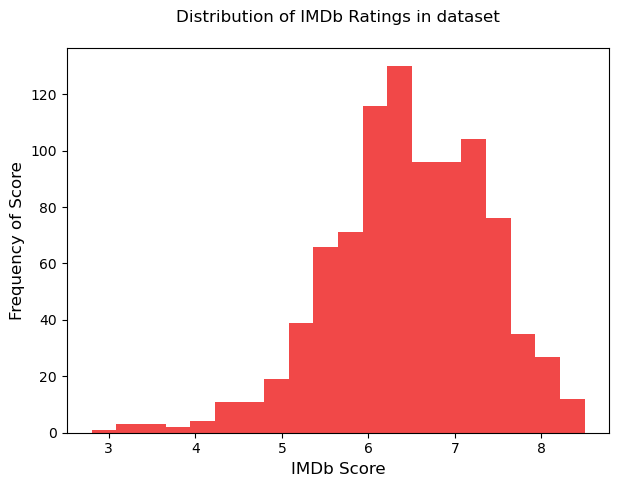

In [14]:
fig, ax = plt.subplots(figsize=(7,5))
df['averageRating'].hist(ax=ax, color='#f14848', bins=20, grid=False)
ax.set_title('Distribution of IMDb Ratings in dataset\n')
ax.set_xlabel('IMDb Score', size=12),
ax.set_ylabel('Frequency of Score', size=12)
fig.set_facecolor('white')

In [15]:
df['averageRating'].describe()

count    922.000000
mean       6.471909
std        0.893870
min        2.800000
25%        6.000000
50%        6.500000
75%        7.100000
max        8.500000
Name: averageRating, dtype: float64

### Train-Test Split

In [16]:
features = df.drop(columns=['averageRating'])
target = df['averageRating']

X_train: Used for training the model and engineering features

X_val: Used for selecting a model

X_test: Used to score the final model

In [17]:
# Splitting the full dataset into training and testing data

X_train, X_test, y_train, y_test = train_test_split(
    features, target, test_size=0.2, random_state=seed
)

# Splitting off a validation set

X_test, X_val, y_test, y_val = train_test_split(
    X_test, y_test, test_size=.5, random_state=seed
)

### Cleaning and tokenizing comments

In [18]:
def clean_comments(comments_list):
    
    # Make everything lowercase
    cleaned = [comment.lower() for comment in comments_list]

    # Remove excessive white space and newlines
    cleaned = [comment.replace("\n", " ") for comment in cleaned]
    cleaned = [re.sub(pattern=r' {2,}', repl=' ', string=comment) for comment in cleaned]

    # Ensure apostrophes and quotation marks are consistent
    cleaned = [re.sub(r"’|‘", repl="'", string=comment) for comment in cleaned]
    cleaned = [re.sub(r"“|”", repl='"', string=comment) for comment in cleaned]
    
    return cleaned

In [19]:
X_train['comments'] = X_train['comments'].apply(clean_comments)

In [20]:
# Preview 

X_train.sample(5)['comments']

53296    ["luke skywalker projecting a force ghost across the galaxy to fuck with kylo ren" is the level ...
38838    [oh no bryson look out! oh my god, he's got airpods in, he can't hear us! oh fuck!, the pacing o...
6652     [this is a great example of a straightforward, formulaic movie elevated by \*excellent\* perform...
24543    [the sister's reaction to the email annoyed the shit out of me. you and your sister are supposed...
1473     ["what were you thinking" "you told me not to think!" fucking 10/10, very impressed with the way...
Name: comments, dtype: object

#### Why not remove punctuation?

Removing punctuation is a common step in cleaning text for NLP. I'm choosing not to yet since I plan to lemmatize words and extract part of speech tags. Doing so requires keeping grammatical context in the text, which would be lost if I removed punctuation at this point. Punctuation will be removed in a future step.

#### Setting up a tokenizer with SpaCy

In [21]:
# Disabling certain components to keep it light

nlp = spacy.load(
    "en_core_web_sm",
    disable=[
        "ner", "textcat", "custom",
        "entity_linker", "entity_linker",
        "textcat_multilabel", "transformer"
    ]
    )

In [22]:
# List of comments to use an example
example_comments = X_train.loc[3957]['comments']
display(example_comments[:3])

["best gag: start of the riddler's vlog thanking his followers for commenting",
 'confirmed: the riddler is a reddit mod',
 'i can watch batman slowly walking to 4 piano notes all day']

In [23]:
# How Spacy's "nlp" object works:

print("Spacy Object:")
print(nlp.pipe(example_comments))
print()
print("The result is a list of docs. Each doc is a comment:")
print(list(nlp.pipe(example_comments))[0])
print(list(nlp.pipe(example_comments))[1])
print(list(nlp.pipe(example_comments))[2])
print()
print("Type:")
print(type((list(nlp.pipe(example_comments)))[0]))
print()
print("Tokens:")
print([t.text for t in list(nlp.pipe(example_comments))[0]])
print([t.text for t in list(nlp.pipe(example_comments))[1]])
print([t.text for t in list(nlp.pipe(example_comments))[2]])

Spacy Object:
<generator object Language.pipe at 0x0000025E03B2C200>

The result is a list of docs. Each doc is a comment:
best gag: start of the riddler's vlog thanking his followers for commenting
confirmed: the riddler is a reddit mod
i can watch batman slowly walking to 4 piano notes all day

Type:
<class 'spacy.tokens.doc.Doc'>

Tokens:
['best', 'gag', ':', 'start', 'of', 'the', 'riddler', "'s", 'vlog', 'thanking', 'his', 'followers', 'for', 'commenting']
['confirmed', ':', 'the', 'riddler', 'is', 'a', 'reddit', 'mod']
['i', 'can', 'watch', 'batman', 'slowly', 'walking', 'to', '4', 'piano', 'notes', 'all', 'day']


The tokenizing process appears to work. It treats most punctuation as tokens, so I will likely add punctuation to my stop word list.

#### New column: Converting each reddit discussion into a list of SpaCy docs. Each doc is a comment.

In [24]:
# This cell can take over 7 minutes to run

X_train['spacy_comments'] = X_train['comments'].apply(lambda x: list(nlp.pipe(x)))

#### Tokenizing

#### I plan to make multiple tokenized versions of each comment.

* Basic version: Any word with at least two letters. Strips the symbols for hashtags (#) and mentions(@)
* Basic version, excluding stop words
* Lemmatized version of basic version
* Lemmatized version of basic version, exluding stop words.

In [25]:
condition = lambda x: all([x.is_ascii, not x.like_url, not x.is_digit, not x.is_punct])

In [26]:
def spacy_tokenize(list_of_docs):
    """
    Takes in a list of SpaCy documents.
    Converts them into one giant list of tokens as strings.
    Omits punctuation, non-ASCII characters, digits, URLs.
    """
    token_mask = \
        lambda x: all(
            [x.is_ascii, not x.like_url, not x.is_digit, not x.is_punct]
            )
    tokens_by_doc = [[t.text for t in doc if token_mask(t)] for doc in list_of_docs]
    tokens_all_together = list(itertools.chain.from_iterable(tokens_by_doc))
    return tokens_all_together

In [27]:
X_train['tokens'] = X_train['spacy_comments'].apply(spacy_tokenize)

In [28]:
X_train.head()

,id,tconst,title,numVotes,runtimeMinutes,genres,comments,n_comments,neg_norm,pos_norm,spacy_comments,tokens
5057,s4a7gj,tt10095582,the tragedy of macbeth,33175,105.0,"Drama,Mystery,Thriller","[kathryn hunter playing all 3 witches and the old man was phenomenal, while i was lost some with...",96,0.135417,0.687500,"[(kathryn, hunter, playing, all, 3, witches, and, the, old, man, was, phenomenal), (while, i, wa...","[kathryn, hunter, playing, all, witches, and, the, old, man, was, phenomenal, while, i, was, los..."
2183,u93jxh,tt11291274,the unbearable weight of massive talent,71143,107.0,"Action,Comedy,Crime",[nic cage and pedro pascal tripping balls and having an emotional crisis over an 8 ft wall will ...,97,0.185567,0.597938,"[(nic, cage, and, pedro, pascal, tripping, balls, and, having, an, emotional, crisis, over, an, ...","[nic, cage, and, pedro, pascal, tripping, balls, and, having, an, emotional, crisis, over, an, f..."
40719,a5yk8k,tt7905466,they shall not grow old,34675,99.0,"Documentary,History,War","[biggest takeaway is the brit's will do just about anything to get their cup of tea. , >""they sh...",117,0.230088,0.513274,"[(biggest, takeaway, is, the, brit, 's, will, do, just, about, anything, to, get, their, cup, of...","[biggest, takeaway, is, the, brit, 's, will, do, just, about, anything, to, get, their, cup, of,..."
2044,ueb30t,tt12519030,hatching,6807,91.0,Horror,[the only monster in this movie was the bitch of a mother. i liked the character design of the e...,22,0.409091,0.318182,"[(the, only, monster, in, this, movie, was, the, bitch, of, a, mother, ., i, liked, the, charact...","[the, only, monster, in, this, movie, was, the, bitch, of, a, mother, i, liked, the, character, ..."
67123,4ukw1u,tt4853102,batman: the killing joke,56967,76.0,"Action,Animation,Crime","[batman doing batgirl in cowgirl position is like something out of a bad porn parody. and sure, ...",97,0.545455,0.227273,"[(batman, doing, batgirl, in, cowgirl, position, is, like, something, out, of, a, bad, porn, par...","[batman, doing, batgirl, in, cowgirl, position, is, like, something, out, of, a, bad, porn, paro..."


In [29]:
time_check()

Time check: 6 minutes and 19 seconds


#### Stop words

To make a comprehensive list of stop words, I will combine the default lists from the NLTK and SpaCy libraries.

In [30]:
sw_spacy = list(nlp.Defaults.stop_words)
sw_nltk = stopwords.words('english')
punct = list(string.punctuation)
stopword_list = list(set(sw_spacy + sw_nltk + punct))

In [31]:
len(stopword_list)

414

Are there any other other words I should include in stop words?

C:\Users\zshoo\AppData\Local\Temp\ipykernel_35508\2472491179.py:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(tokens, rotation=45, ha='right')


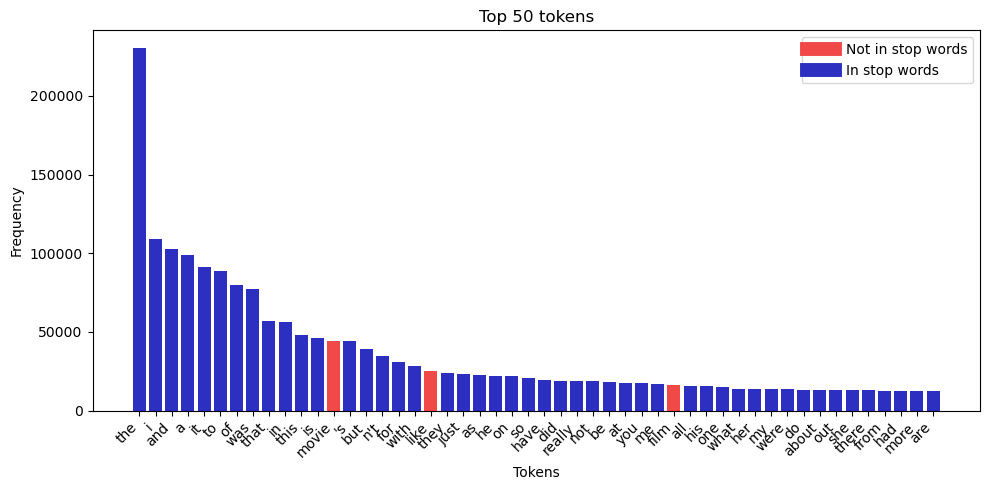

In [32]:
fig, ax = plt.subplots(figsize=(10,5))

top_50_tok = OrderedDict(
    FreqDist(X_train['tokens'].explode()).most_common(50)
    )

tokens = list(top_50_tok.keys())
freq = list(top_50_tok.values())
extra_sw = [t for t in tokens if t not in stopword_list]
ax.bar(x=tokens, height=freq, color=['#f14848' if t in extra_sw else '#2c2fbf' for t in tokens])
ax.set_ylabel('Frequency', size=10)
ax.set_xlabel('Tokens', size=10)
ax.set_xticklabels(tokens, rotation=45, ha='right')
ax.set_title('Top 50 tokens')
custom_bars = [Line2D([0], [0], color='#f14848', lw=10), Line2D([0], [0], color='#2c2fbf', lw=10)]
ax.legend(custom_bars, ['Not in stop words', 'In stop words'], fontsize=10)
fig.set_facecolor('white');
plt.tight_layout()
# plt.savefig(f'./images/top_50_tokens', dpi=500)
plt.show()

The tokens **movie**, **like**, and **film** occur as frequently as many stop words. I'll add them to the stop word list. These words get thrown around so often in r/movies that they probably don't contribute much value in an ML context.

In [33]:
stopword_list.extend(["movie", "like", "film"])

#### Making tokens without stop words:

In [34]:
X_train['tokens_no_sw'] = X_train['tokens'].apply(
    lambda x: [t for t in x if t not in stopword_list]
)

Seeing most frequent tokens without stopwords:

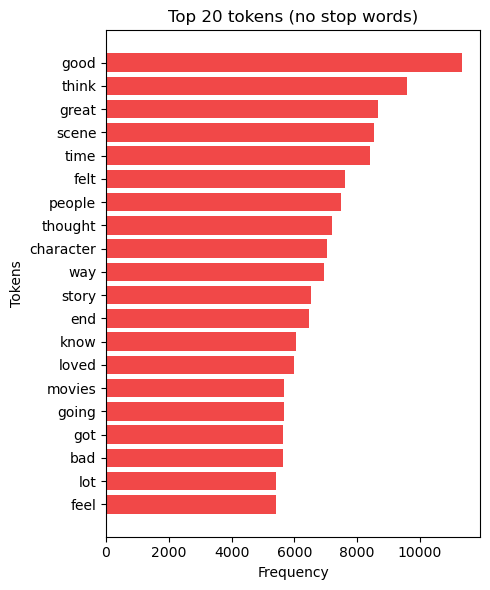

In [35]:
fig, ax = plt.subplots(figsize=(5,6))

top_20_tok = OrderedDict(
    FreqDist(X_train['tokens_no_sw'].explode()).most_common(20)
    )

tokens = list(top_20_tok.keys())[::-1]
freq = list(top_20_tok.values())[::-1]
ax.barh(y=tokens, width=freq, color='#f14848')
ax.set_ylabel('Tokens', size=10)
ax.set_xlabel('Frequency', size=10)
ax.set_title('Top 20 tokens (no stop words)')
fig.set_facecolor('white');
plt.tight_layout()
# plt.savefig(f'./images/top_20_tokens_no_sw', dpi=500)
plt.show()

<!-- Interesting that commenters used elipses ("...") often enough that it's in the top 20 tokens. -->

Previewing the resulting features:

In [36]:
X_train.sample(5)

,id,tconst,title,numVotes,runtimeMinutes,genres,comments,n_comments,neg_norm,pos_norm,spacy_comments,tokens,tokens_no_sw
10401,p3ztri,tt10366460,coda,124816,111.0,"Comedy,Drama,Music",[that scene between ruby and frank in the back of their truck as he 'listens' to her sing - what...,100,0.150000,0.690000,"[(that, scene, between, ruby, and, frank, in, the, back, of, their, truck, as, he, ', listens, '...","[that, scene, between, ruby, and, frank, in, the, back, of, their, truck, as, he, listens, to, h...","[scene, ruby, frank, truck, listens, sing, brilliantly, acted, scene, excellent, heartwarming, l..."
62184,5ql91v,tt4385888,20th century women,45583,119.0,"Comedy,Drama",[i don't think it's possible to watch greta gerwig in anything and not immediately want to be be...,29,0.103448,0.758621,"[(i, do, n't, think, it, 's, possible, to, watch, greta, gerwig, in, anything, and, not, immedia...","[i, do, n't, think, it, 's, possible, to, watch, greta, gerwig, in, anything, and, not, immediat...","[think, possible, watch, greta, gerwig, immediately, want, best, friends, good, small, character..."
13621,nsj230,tt11084896,spirit untamed,3700,88.0,"Adventure,Animation,Comedy",[it's the same plot as every horse girl movie ever made but it looks like the video game that wo...,10,0.300000,0.600000,"[(it, 's, the, same, plot, as, every, horse, girl, movie, ever, made, but, it, looks, like, the,...","[it, 's, the, same, plot, as, every, horse, girl, movie, ever, made, but, it, looks, like, the, ...","[plot, horse, girl, looks, video, game, come, free, straight, dvd, barbie, early, 2000s, dreamwo..."
52723,7llz2i,tt5580390,the shape of water,415698,123.0,"Drama,Fantasy,Romance",[theres a thread that pops up here every once in a while about what people think is the best act...,93,0.355556,0.422222,"[(there, s, a, thread, that, pops, up, here, every, once, in, a, while, about, what, people, thi...","[there, s, a, thread, that, pops, up, here, every, once, in, a, while, about, what, people, thin...","[thread, pops, people, think, best, acting, scene, sally, hawkins, scene, begging, giles, help, ..."
43626,9n9qjv,tt6628394,bad times at the el royale,149216,141.0,"Crime,Drama,Mystery","[""how many people have you killed?"" ""123."" i had no idea he was gonna end up being my favorite c...",99,0.360825,0.453608,"[("", how, many, people, have, you, killed, ?, "", "", 123, ., "", i, had, no, idea, he, was, gon, n...","[how, many, people, have, you, killed, i, had, no, idea, he, was, gon, na, end, up, being, my, f...","[people, killed, idea, gon, na, end, favorite, character, jesus, christ, glad, face, bottle, sma..."


### Further breaking down tokens
#### Lemmatization
Now I want to make a version of these tokenized comments where each word is lemmatized. __Lemmatization__ is a technique that uses grammatical context to convert a word into its root word, or "lemma," which is often its noun form. For example, the tool would change the words "running," "ran," and "runs" into "run."

Essentially I am another tokenizing function, where the output is lemmatized tokens instead of just plain tokens.

In [37]:
def spacy_lemmatize(list_of_docs):
    """
    Takes in a list of SpaCy documents.
    Converts them into one giant list of lemmas as strings.
    Omits punctuation, non-ASCII characters, digits, URLs.
    """
    token_mask = \
        lambda x: all(
            [x.is_ascii, not x.like_url, not x.is_digit, not x.is_punct]
            )
    lemmas_by_doc = [[t.lemma_.lower() for t in doc if token_mask(t)] for doc in list_of_docs]
    lemmas_all_together = list(itertools.chain.from_iterable(lemmas_by_doc))
    return lemmas_all_together

In [38]:
X_train['lemmas'] = \
    X_train['spacy_comments'].apply(spacy_lemmatize)

In [39]:
# Check most common lemmas

FreqDist(X_train['lemmas'].explode()).most_common(20)

[('the', 230062),
 ('be', 220943),
 ('i', 126206),
 ('and', 102878),
 ('a', 99085),
 ('it', 91237),
 ('to', 89996),
 ('of', 79690),
 ('that', 56671),
 ('in', 56066),
 ('not', 54935),
 ('movie', 50186),
 ('this', 48180),
 ('do', 42630),
 ('have', 40367),
 ('but', 39437),
 ('for', 30745),
 ('he', 30259),
 ('like', 30252),
 ('they', 30038)]

#### Lemmatized comments without stop words
In order to make the lemmatized tokens without stop words, I will also need to lemmatize the stop words.

This has to be done to the stop words while they are still within the string because SpaCy uses grammatical context to lemmatize.

In [40]:
stopword_list_lem = []

sw_lem_Series = \
    X_train['spacy_comments'].apply(
        lambda x: [[t.lemma_.lower() for t in doc if t.text.lower() in stopword_list] for doc in x]
    )

sw_lem_Series = sw_lem_Series.apply(lambda x: list(itertools.chain.from_iterable(x)))

for row in sw_lem_Series:
    stopword_list_lem.extend(row)

stopword_list_lem = list(set(stopword_list_lem))

In [41]:
# Lemmatized tokens, excluding stop words

X_train['lemmas_no_sw'] = X_train['lemmas'].apply(
    lambda x: [l for l in x if l not in stopword_list_lem]
    )

**Seeing most frequent lemmas without stopwords:**

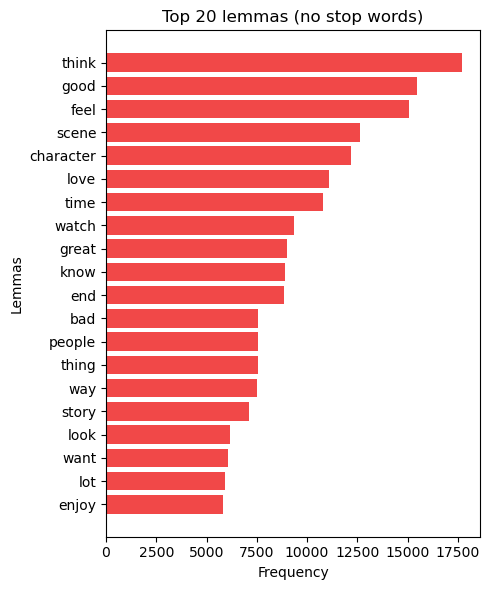

In [42]:
fig, ax = plt.subplots(figsize=(5,6))

top_20_lem = OrderedDict(
    FreqDist(X_train['lemmas_no_sw'].explode()).most_common(20)
    )

tokens = list(top_20_lem.keys())[::-1]
freq = list(top_20_lem.values())[::-1]
ax.barh(y=tokens, width=freq, color='#f14848')
ax.set_ylabel('Lemmas', size=10)
ax.set_xlabel('Frequency', size=10)
ax.set_title('Top 20 lemmas (no stop words)')
fig.set_facecolor('white');
plt.tight_layout()
# plt.savefig(f'./images/top_20_lemmas_no_sw', dpi=500)
plt.show()

#### Visualizing frequency distribution of tokens and lemmas for higher and lower IMDb scores:

In [43]:
print(f"Mean of y_train: {np.round(y_train.mean(), 2)}")
print(f"Median of y_train: {np.round(y_train.median(), 2)}")

Mean of y_train: 6.48
Median of y_train: 6.5


Artificially giving y_train two classes (for visualization purposes).

1: Above average

0: Below average

In [44]:
y_train_class = y_train.apply(lambda x: int(x > y_train.mean()))
y_train_class.head()

5057     1
2183     1
40719    1
2044     0
67123    0
Name: averageRating, dtype: int64

In [45]:
def plot_freqdict_classes(series, y, token_type='Tokens (unspecified kind))', cutoff=20):
    fig, axes = plt.subplots(ncols=2, figsize=(10, 5))
    fd_0 = FreqDist(series[y==0].explode()).most_common(cutoff)
    fd_0 = OrderedDict(fd_0)
    tokens_0 = list(fd_0.keys())[::-1]
    freq_0 = list(fd_0.values())[::-1]
    fd_1 = FreqDist(series[y==1].explode()).most_common(cutoff)
    fd_1 = OrderedDict(fd_1)
    tokens_1 = list(fd_1.keys())[::-1]
    freq_1 = list(fd_1.values())[::-1]
    shared_tokens = [t for t in tokens_0 if t in tokens_1]
    axes[0].barh(y=tokens_0, width=freq_0, color=['C6' if token in shared_tokens else 'C0' for token in tokens_0])
    axes[1].barh(y=tokens_1, width=freq_1, color=['C6' if token in shared_tokens else 'C0' for token in tokens_1])
    axes[0].set_ylabel('Tokens', size=10)
    axes[0].set_xlabel('Frequency', size=10)
    axes[1].set_xlabel('Frequency', size=10)
    fig.suptitle(f'Top {cutoff} {token_type}', size=15)
    axes[0].set_title('Below average IMDb Score')
    axes[1].set_title('Above average average IMDb Score')
    custom_bars = [Line2D([0], [0], color='C6', lw=10), Line2D([0], [0], color='C0', lw=10)]
    axes[0].legend(custom_bars, ['In common', 'Not in common'])
    axes[1].legend(custom_bars, ['In common', 'Not in common'])
    fig.set_facecolor('white');
    plt.tight_layout()
#     plt.savefig(f'./images/top_20_{series.name}', dpi=500)
    plt.show()


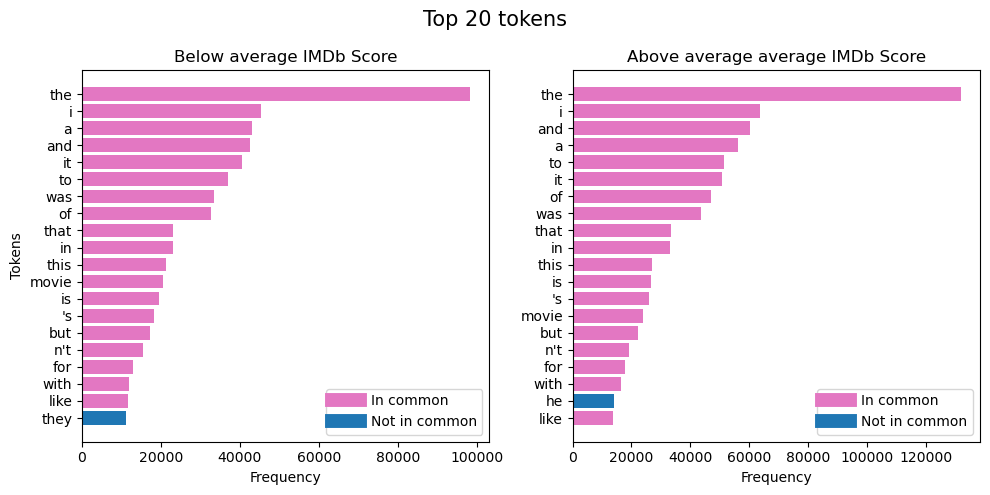

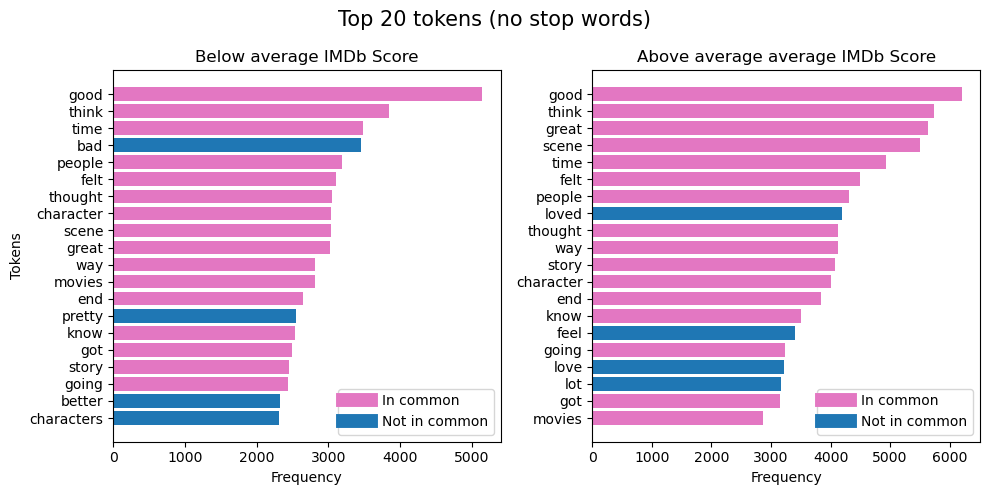

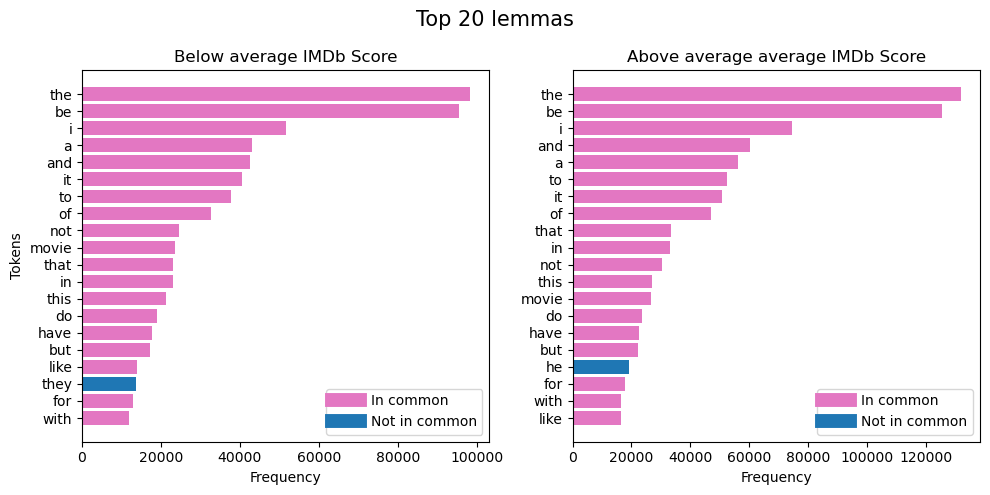

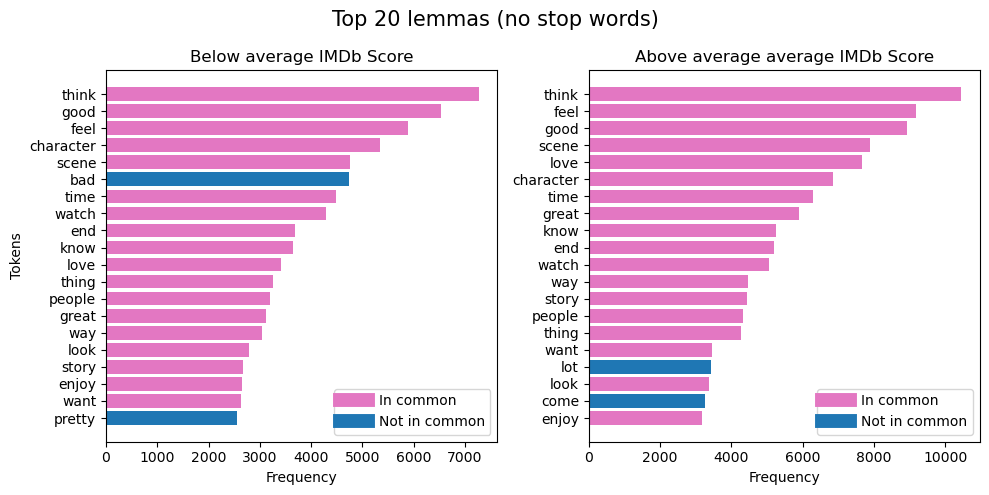

In [46]:
plot_freqdict_classes(X_train['tokens'], y_train_class, 'tokens')
plot_freqdict_classes(X_train['tokens_no_sw'], y_train_class, 'tokens (no stop words)')
plot_freqdict_classes(X_train['lemmas'], y_train_class, 'lemmas')
plot_freqdict_classes(X_train['lemmas_no_sw'], y_train_class, 'lemmas (no stop words)')

## DISCUSSION OF THIS ^^^ TK TK TK 

### More linguistic feature engineering
I will use the SpaCy library to extract more linguistic features from the comments.

### Vectorized part of speech (POS) tags
The SpaCy library is pre-trained to parse through sentences and identify each word's grammatical part of speech.

Here are some examples of what the tool can identify:

In [47]:
options_displacy_pos = {'compact':True, 'distance':90, 'bg':'#3056ff', 'color':'fff'}

for idx in [2, 5, 12]:
    print(example_comments[idx])
    displacy.render(nlp(example_comments[idx]), style='dep', jupyter=True, options=options_displacy_pos)

i can watch batman slowly walking to 4 piano notes all day


the whole scene with the riddler talking about "bruce wayne" had me hooked. i hope paul dano returns for the sequel.


that fight in the dark only being lit up by gunfire was absolutely incredible.


I plan to use this SpaCy capability in order to vectorize the universal [parts of speech](https://universaldependencies.org/u/pos/all.html) of each comment.

First, I'll convert each token into a string of its POS tag.

In [48]:
def spacy_pos(list_of_docs):
    """
    Takes in a list of SpaCy documents.
    Converts them into one giant list of POS tags as strings.    
    Omits punctuation, non-ASCII characters, digits, URLs.
    """
    token_mask = \
        lambda x: all(
            [x.is_ascii, not x.like_url, not x.is_digit, not x.is_punct]
            )
    pos_by_doc = [[t.pos_ for t in doc if token_mask(t)] for doc in list_of_docs]
    pos_all_together = list(itertools.chain.from_iterable(pos_by_doc))
    return pos_all_together

In [49]:
X_train['spacy_pos'] = X_train['spacy_comments'].apply(spacy_pos)

In [50]:
time_check()

Time check: 7 minutes and 60 seconds


In order to make the POS vectors, I'm using scikit-learn's CountVectorizer in a slightly unorthodox way. I'm using it to count POS tags rather than tokens.

In [51]:
# Making dataframes of vectorized POS tags

pos_vectorizer = CountVectorizer(tokenizer=spacy_pos, lowercase=False)
pos_vec_train = pos_vectorizer.fit_transform(X_train['spacy_comments'])
pos_vec_df_train = pd.DataFrame(
        pos_vec_train.toarray(),
        columns=pos_vectorizer.get_feature_names_out(),
        index=X_train.index
)

Changing this to the proportion of each POS within each Reddit thread.

In [52]:
pos_vec_df_norm_train = pos_vec_df_train.div(pos_vec_df_train.sum(axis=1), axis=0)
pos_vec_df_norm_train.columns = pos_vec_df_train.columns + '_norm'
pos_vec_df_norm_train.head()

,ADJ_norm,ADP_norm,ADV_norm,AUX_norm,CCONJ_norm,DET_norm,INTJ_norm,NOUN_norm,NUM_norm,PART_norm,PRON_norm,PROPN_norm,PUNCT_norm,SCONJ_norm,SPACE_norm,SYM_norm,VERB_norm,X_norm
5057,0.090733,0.095666,0.080514,0.074348,0.040521,0.103418,0.001586,0.179704,0.004405,0.030127,0.123326,0.025899,0.000000,0.024665,0.000176,0.00000,0.123855,0.001057
2183,0.101234,0.099532,0.066780,0.072735,0.038494,0.097193,0.001489,0.190345,0.004466,0.027860,0.121650,0.032539,0.000213,0.022756,0.001063,0.00000,0.121225,0.000425
40719,0.085846,0.107975,0.069061,0.068142,0.041837,0.106388,0.000835,0.193904,0.005762,0.026138,0.121503,0.013194,0.000251,0.026388,0.000084,0.00000,0.132192,0.000501
2044,0.079865,0.097300,0.053431,0.072553,0.039370,0.109111,0.003375,0.196288,0.002812,0.038808,0.129359,0.012373,0.000000,0.031496,0.000000,0.00000,0.133858,0.000000
67123,0.084089,0.092589,0.071373,0.083737,0.039340,0.100105,0.002810,0.178012,0.005901,0.035616,0.129259,0.020724,0.000140,0.026203,0.000070,0.00007,0.129470,0.000492


#### Checking for linear relationship between POS tags and IMDb score.

In [53]:
def get_pearson_r(X, y=y_train):
    return round(pearsonr(X, y_train)[0], 4)

def get_p(X, y=y_train):
    return pearsonr(X, y_train)[1]
    
def is_p_significant(X, y=y_train):
    return pearsonr(X, y_train)[1] < 0.05

POS_correlations =pd.DataFrame(
    pos_vec_df_norm_train.agg(
        [get_pearson_r, get_p, is_p_significant]
        )).T

POS_correlations

,get_pearson_r,get_p,is_p_significant
ADJ_norm,-0.0706,0.055521,False
ADP_norm,0.2962,0.0,True
ADV_norm,0.0003,0.994106,False
AUX_norm,-0.27,0.0,True
CCONJ_norm,0.0024,0.948326,False
DET_norm,-0.123,0.000819,True
INTJ_norm,-0.211,0.0,True
NOUN_norm,0.0129,0.726912,False
NUM_norm,-0.0881,0.016791,True
PART_norm,-0.1528,0.000031,True


Pretty much all these relationships are weak, but I will still include at least the ones that have a significant relationship at a p-value of 0.05.

In [54]:
somewhat_significant_POS = \
    POS_correlations.query("is_p_significant == True").index.tolist()
somewhat_significant_POS

['ADP_norm',
 'AUX_norm',
 'DET_norm',
 'INTJ_norm',
 'NUM_norm',
 'PART_norm',
 'PROPN_norm',
 'SCONJ_norm',
 'SYM_norm']

In [55]:
pos_vec_df_norm_train = pos_vec_df_norm_train[somewhat_significant_POS]

## More feature engineering

This new dataframe will consist of miscellaneous other features.

I already have a **sentiment score** for each comment section, so I'll include that.

Here are some other **meta-features** I'll explore:

* Average character count of comment per discussion
* Average token or lemma length per discussion (excluding stop words).
* Proportion of stop words
* Proportion of unique tokens or lemmas (excluding stop words).

I drew inspiration for some of these features from [this Kaggle entry](https://www.kaggle.com/code/gunesevitan/nlp-with-disaster-tweets-eda-cleaning-and-bert/notebook) by Gunes Evitan.

Making a new DataFrame composed of the miscellaneous features I listed above AND sentiment:

In [56]:
meta_features_df_train = X_train[['pos_norm', 'neg_norm']].copy()

# Average character count of comment per discussion
meta_features_df_train['avg_char_count_comments'] = \
    X_train['comments'].apply(lambda x: np.mean([len(comment) for comment in x]))

# Average token length per discussion excluding stop words.
meta_features_df_train['mean_token_length'] = \
    X_train['tokens_no_sw'].apply(lambda x: np.mean([len(l) for l in x]))

# Average lemma length per discussion excluding stop words.
meta_features_df_train['mean_lemma_length'] = \
    X_train['lemmas_no_sw'].apply(lambda x: np.mean([len(l) for l in x]))

# Proportion of unique tokens excluding stop words.
meta_features_df_train['prop_unique_tokens_no_sw'] = \
    X_train['tokens_no_sw'].apply(lambda x: len(set(x))/len(x))

# Proportion of unique lemmas excluding stop words.
meta_features_df_train['prop_unique_lemmas_no_sw'] = \
    X_train['lemmas_no_sw'].apply(lambda x: len(set(x))/len(x))

# Proportion of stop words (tokens)
meta_features_df_train['sw_proportion_tok'] = \
    X_train['tokens'].apply(lambda x: len([w for w in x if w in stopword_list]))\
        / X_train['tokens'].apply(len)

# Proportion of stop words (lemmas)
meta_features_df_train['sw_proportion_lem'] = \
    X_train['lemmas'].apply(lambda x: len([w for w in x if w in stopword_list_lem]))\
        / X_train['lemmas'].apply(len)

meta_features_df_train.head()

,pos_norm,neg_norm,avg_char_count_comments,mean_token_length,mean_lemma_length,prop_unique_tokens_no_sw,prop_unique_lemmas_no_sw,sw_proportion_tok,sw_proportion_lem
5057,0.687500,0.135417,323.406250,6.379057,6.125226,0.505842,0.452532,0.592847,0.610289
2183,0.597938,0.185567,259.185567,5.837754,5.566740,0.508060,0.461160,0.591025,0.611229
40719,0.513274,0.230088,560.068376,6.342327,6.060257,0.397766,0.344927,0.603841,0.623048
2044,0.318182,0.409091,425.409091,5.926027,5.706056,0.680822,0.633678,0.589426,0.619235
67123,0.227273,0.545455,784.742268,6.030621,5.782121,0.351789,0.306527,0.605409,0.624377


#### Checking for linear relationship between the miscellaneous features and IMDb score.

In [57]:
pd.DataFrame(
    meta_features_df_train.agg(
        [get_pearson_r, get_p, is_p_significant]
        )).T

,get_pearson_r,get_p,is_p_significant
pos_norm,0.5964,0.0,True
neg_norm,-0.6257,0.0,True
avg_char_count_comments,0.1307,0.000375,True
mean_token_length,0.282,0.0,True
mean_lemma_length,0.2739,0.0,True
prop_unique_tokens_no_sw,-0.1587,0.000015,True
prop_unique_lemmas_no_sw,-0.1626,0.000009,True
sw_proportion_tok,-0.1027,0.005244,True
sw_proportion_lem,-0.1222,0.000888,True


Again, most of these are weak relationships

Surprisingly, they're all nonetheless significant. For simplicity's sake, I'll only keep the ones centered around lemmas, if there is an option.

In [58]:
meta_features_df_train =\
    meta_features_df_train.drop(
        columns=['mean_token_length', 'prop_unique_tokens_no_sw', 'sw_proportion_tok']
        )

I can visualize density plots for these meta-features, separated by the artificial classes I created earlier (below or above average IMDb score). The features `mean_lemma_length` and `prop_unique_lemmas_no_sw` appear to have a difference in distribution.

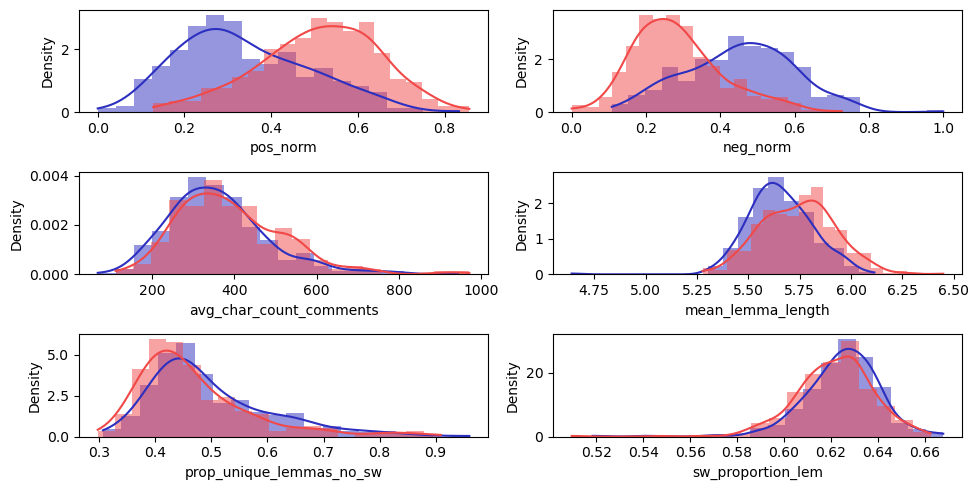

In [59]:
kwargs_histplot = {'kde':True, 'stat':"density", 'linewidth':0, 'bins':20}
color_below = '#2c2fbf'
color_above ='#f14848'

fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(10,5))
fl_ax = axes.flatten()
fig.set_facecolor('white')
for idx, ftr in list(enumerate(meta_features_df_train.columns)):
    sns.histplot(meta_features_df_train[ftr][y_train_class==0], ax=fl_ax[idx], **kwargs_histplot, color=color_below)
    sns.histplot(meta_features_df_train[ftr][y_train_class==1], ax=fl_ax[idx], **kwargs_histplot, color=color_above)

plt.tight_layout()
# plt.savefig('./images/meta_features_basic.png', dpi=500)
plt.show()

In [60]:
time_check()

Time check: 8 minutes and 45 seconds


## Vectorizing the comment sections

I've engineered linguistic features and meta-features. Now I'm going to make the actual text of the comments interpretable by a machine learning model using [scikit-learn's TF-IDF vectorizer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html). This vectorizer returns the [**term frequency-inverse document frequency**](https://towardsdatascience.com/tf-idf-for-document-ranking-from-scratch-in-python-on-real-world-dataset-796d339a4089) (TF-IDF) of each token in each movie comment section.

TF-IDF is a measurement that takes into account the 1) token's frequency within the document (term frequency) and 2) how rare it is for the token to appear in a document (inverse document frequency). 

I'm making two versions of the vectorized comments:
* Plain tokens
* Lemmatized Tokens

In [62]:
tok_tfidf = TfidfVectorizer(
    tokenizer=spacy_tokenize,
    stop_words=stopword_list,
    max_features=500,
    lowercase=False
    )

tok_X_train_vec = tok_tfidf.fit_transform(X_train['spacy_comments'])

tok_X_train_vec_df = pd.DataFrame(
    tok_X_train_vec.toarray(),
    columns=tok_tfidf.get_feature_names_out(),
    index=X_train.index
    )
tok_X_train_vec_df.head() 

,able,absolutely,act,acting,action,actor,actors,actual,actually,ago,...,wow,writing,written,wrong,x200b,yeah,year,years,yes,young
5057,0.000000,0.089815,0.013060,0.090062,0.000000,0.101898,0.109428,0.013819,0.030527,0.044268,...,0.016441,0.000000,0.030057,0.000000,0.00000,0.000000,0.079458,0.059492,0.015647,0.000000
2183,0.016279,0.000000,0.122176,0.026329,0.176280,0.034045,0.047986,0.016160,0.011899,0.000000,...,0.019225,0.048694,0.017574,0.015856,0.00000,0.036083,0.066369,0.013914,0.018297,0.097711
40719,0.029490,0.061834,0.000000,0.004770,0.006387,0.000000,0.000000,0.052693,0.034489,0.050013,...,0.000000,0.000000,0.000000,0.005745,0.04443,0.000000,0.062518,0.055450,0.013258,0.035400
2044,0.000000,0.000000,0.053394,0.046026,0.030815,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.030721,0.000000,0.00000,0.031538,0.023204,0.000000,0.000000,0.034162
67123,0.009752,0.043257,0.050319,0.051262,0.015840,0.005099,0.004791,0.058086,0.074849,0.020674,...,0.017276,0.024309,0.000000,0.018998,0.00000,0.032424,0.007952,0.033341,0.016442,0.029268


In [63]:
lem_tfidf = TfidfVectorizer(
    tokenizer=spacy_lemmatize, 
    stop_words=stopword_list_lem,
    max_features=500,
    lowercase=False
    )

lem_X_train_vec = lem_tfidf.fit_transform(X_train['spacy_comments'])

lem_X_train_vec_df = pd.DataFrame(
    lem_X_train_vec.toarray(),
    columns=lem_tfidf.get_feature_names_out(),
    index=X_train.index
    )
lem_X_train_vec_df.head() 

,able,absolutely,accent,act,acting,action,actor,actress,actual,actually,...,wow,write,writer,writing,wrong,x200b,yeah,year,yes,young
5057,0.000000,0.077337,0.018636,0.028062,0.075964,0.011727,0.151348,0.030369,0.011899,0.026286,...,0.014111,0.031563,0.000000,0.000000,0.000000,0.000000,0.000000,0.105287,0.013473,0.000000
2183,0.014562,0.000000,0.000000,0.124998,0.013183,0.142456,0.061286,0.000000,0.014455,0.010644,...,0.017142,0.051123,0.000000,0.031249,0.014122,0.000000,0.032277,0.063952,0.016367,0.109370
40719,0.028453,0.059659,0.000000,0.004441,0.000000,0.005567,0.000000,0.000000,0.050840,0.033276,...,0.000000,0.000000,0.000000,0.000000,0.005518,0.042867,0.000000,0.099963,0.012792,0.030528
2044,0.000000,0.000000,0.000000,0.042363,0.049147,0.026554,0.000000,0.034383,0.000000,0.000000,...,0.000000,0.023823,0.000000,0.000000,0.000000,0.000000,0.030082,0.019868,0.000000,0.029124
67123,0.009632,0.042723,0.000000,0.071405,0.021800,0.018845,0.008107,0.000000,0.057369,0.073925,...,0.017007,0.025361,0.005848,0.020669,0.018682,0.000000,0.032024,0.035250,0.016239,0.031004


Finally, I'm going to combine the vectors with the other features I've engineered so far into a two DataFrames (one for tok and one for lem). All features are being scaled, as well.

**This is the DataFrame that the model will train on.**

In [64]:
tok_X_train_combined_df = pd.concat(
    [
        tok_X_train_vec_df,
        pos_vec_df_norm_train, 
        meta_features_df_train,
    ],
    axis=1
    )

# Scaling all features

tok_scaler = StandardScaler()
tok_X_train_combined_df_scaled = tok_scaler.fit_transform(tok_X_train_combined_df)
tok_X_train_combined_df_scaled = pd.DataFrame(tok_X_train_combined_df_scaled, index=X_train.index, columns=tok_X_train_combined_df.columns)

tok_X_train_combined_df_scaled.head()

,able,absolutely,act,acting,action,actor,actors,actual,actually,ago,...,PART_norm,PROPN_norm,SCONJ_norm,SYM_norm,pos_norm,neg_norm,avg_char_count_comments,mean_lemma_length,prop_unique_lemmas_no_sw,sw_proportion_lem
5057,-0.877482,2.126430,-0.391047,1.585067,-0.565078,3.120109,3.213303,-0.199869,-0.714899,1.136742,...,-0.597753,-0.102027,-0.363897,-0.390369,1.526481,-1.439436,-0.424345,2.382721,-0.284469,-0.754956
2183,-0.045496,-1.167629,3.835818,-0.313540,1.058791,0.539277,0.946131,-0.100103,-1.272859,-0.706668,...,-1.152752,0.470668,-0.857989,-0.390369,0.995456,-1.121921,-0.923425,-0.769045,-0.205417,-0.699010
40719,0.629650,1.100182,-0.896951,-0.955808,-0.506246,-0.755651,-0.824539,1.456963,-0.596238,1.375965,...,-1.574615,-1.197633,0.082072,-0.390369,0.493471,-0.840043,1.414831,2.016074,-1.270360,0.004166
2044,-0.877482,-1.167629,1.171384,0.273231,-0.281210,-0.755651,-0.824539,-0.788864,-1.629279,-0.706668,...,1.528047,-1.268409,1.404086,-0.390369,-0.663261,0.293271,0.368351,0.017175,1.375223,-0.222690
67123,-0.379069,0.418850,1.052271,0.429208,-0.419158,-0.561715,-0.647748,1.686808,0.612667,0.154248,...,0.746567,-0.548307,0.034115,-0.188835,-1.202275,1.156627,3.160842,0.446439,-1.622186,0.083208


In [65]:
lem_X_train_combined_df = pd.concat(
    [
        lem_X_train_vec_df,
        pos_vec_df_norm_train, 
        meta_features_df_train,
    ],
    axis=1
    )

# Scaling all features

lem_scaler = StandardScaler()
lem_X_train_combined_df_scaled = lem_scaler.fit_transform(lem_X_train_combined_df)
lem_X_train_combined_df_scaled = pd.DataFrame(lem_X_train_combined_df_scaled, index=X_train.index, columns=lem_X_train_combined_df.columns)

lem_X_train_combined_df_scaled.head()

,able,absolutely,accent,act,acting,action,actor,actress,actual,actually,...,PART_norm,PROPN_norm,SCONJ_norm,SYM_norm,pos_norm,neg_norm,avg_char_count_comments,mean_lemma_length,prop_unique_lemmas_no_sw,sw_proportion_lem
5057,-0.875831,2.041134,0.106076,-0.241776,2.044402,-0.460248,3.964039,0.667146,-0.208905,-0.726349,...,-0.597753,-0.102027,-0.363897,-0.390369,1.526481,-1.439436,-0.424345,2.382721,-0.284469,-0.754956
2183,-0.024126,-1.156335,-0.365891,3.189544,-0.421043,0.978489,1.001940,-0.547117,-0.086750,-1.249500,...,-1.152752,0.470668,-0.857989,-0.390369,0.995456,-1.121921,-0.923425,-0.769045,-0.205417,-0.699010
40719,0.788297,1.310242,-0.365891,-1.077939,-0.938751,-0.528039,-1.013742,-0.547117,1.652059,-0.492572,...,-1.574615,-1.197633,0.082072,-0.390369,0.493471,-0.840043,1.414831,2.016074,-1.270360,0.004166
2044,-0.875831,-1.156335,-0.365891,0.264427,0.991254,-0.297070,-1.013742,0.827665,-0.777581,-1.605500,...,1.528047,-1.268409,1.404086,-0.390369,-0.663261,0.293271,0.368351,0.017175,1.375223,-0.222690
67123,-0.312479,0.610018,-0.365891,1.292443,-0.082668,-0.381904,-0.747091,-0.547117,1.964083,0.866963,...,0.746567,-0.548307,0.034115,-0.188835,-1.202275,1.156627,3.160842,0.446439,-1.622186,0.083208


In [66]:
time_check()

Time check: 30 minutes and 50 seconds


#### Apply all pre-processing steps to test and validation sets.
The function below runs the `test` and `val` sets through the exact same preprocessing steps that the `train` set as undergone.

By default, the function makes use of the exact transformer objects that have been trained on `X_train`, in order to avoid data leakage.

In [67]:
def preprocess_comments(
    df_to_process,
    tokenizer=spacy_tokenize,
    stop_words=stopword_list,
    lem_tokenizer=spacy_lemmatize,
    stop_words_lem=stopword_list_lem,
    trained_pos_vectorizer=pos_vectorizer,
    trained_word_vectorizer=lem_tfidf,
    trained_scaler=lem_scaler,
    return_scaled=True,
    return_cleaned_df=False
):
    """
    Takes in a dataframe with a column named "comments", where each
    row contains a list of individual Reddit comments about a movie.
    All other parameters have default arguments set to specific
    tokenizers, vectorizers, and stop word lists. By default, this 
    function makes use of transformer objects that have been trained 
    on X_train in this notebook, in order to avoid data leakage. If 
    you are reusing this function in a different project, you should
    rewrite the function with your default arguments.

    SUMMARY OF ACTIONS:

    - Clean comments -- Remove URLs, make everything lowercase,
        standardize quotation marks and apostrophes, remove extra
        whitespace and newlines.
    - Convert lists of comments into lists of SpaCy documents.
    - Use SpaCy documents to tokenize comments.
    - Use SpaCy documents to lemmatize comoments.
    - Use SpaCy documents and a fitted Sklearn CountVectorizer 
        object to count and normalize part-of-speech tags; 
        create POS dataframe.
    - Calculate meta-features; create meta-features dataframe.
    - Vectorize lemmas or tokens using a fitted Sklearn 
        TfidfVectorizer object (TF-IDF vectorization).
    - Combine all features dataframes into one.
    - Scale resulting dataframe using a fitted Sklearn 
        StandardScaler.
    - If "return_cleaned_df" parameter set to True, returns
        a dictionary of both the features dataframe and the
        dataframe wit the cleaned and tokenized version of 
        the comments. Else, only returns features.
    """
    comments_df = df_to_process.copy()
    
    comments_df['comments'] = comments_df['comments'].apply(clean_comments)
    comments_df['spacy_comments'] = comments_df['comments'].apply(lambda x: list(nlp.pipe(x)))

    comments_df['tokens'] = comments_df['spacy_comments'].apply(tokenizer)
    comments_df['tokens_no_sw'] = \
        comments_df['tokens'].apply(lambda x: [t for t in x if t not in stop_words])

    comments_df['lemmas'] = comments_df['spacy_comments'].apply(lem_tokenizer)
    comments_df['lemmas_no_sw'] = \
        comments_df['lemmas'].apply(lambda x: [t for t in x if t not in stop_words_lem])

    pos_vec = trained_pos_vectorizer.transform(comments_df['spacy_comments'])
    pos_vec_df = pd.DataFrame(
        pos_vec.toarray(), 
        columns=trained_pos_vectorizer.get_feature_names_out(),
        index=df_to_process.index
    )
    pos_vec_df_norm = pos_vec_df.div(pos_vec_df.sum(axis=1), axis=0)
    pos_vec_df_norm.columns = pos_vec_df.columns + '_norm'
    pos_vec_df_norm = pos_vec_df_norm[somewhat_significant_POS]

    meta_features_df = comments_df[['pos_norm', 'neg_norm']].copy()
    # Average character count of comment per discussion
    meta_features_df['avg_char_count_comments'] = \
        comments_df['comments'].apply(lambda x: np.mean([len(comment) for comment in x]))
    # Average lemma length per discussion. No stop words.
    meta_features_df['mean_lemma_length'] = \
        comments_df['lemmas_no_sw'].apply(lambda x: np.mean([len(l) for l in x]))
    # Proportion of unique lemmas. No stop words.
    meta_features_df['prop_unique_lemmas_no_sw'] = \
        comments_df['lemmas_no_sw'].apply(lambda x: len(set(x))/len(x))
    # Proportion of stop words (lemmas)
    meta_features_df['sw_proportion_lem'] = \
        comments_df['lemmas'].apply(lambda x: len([w for w in x if w in stopword_list_lem]))\
            / comments_df['lemmas'].apply(len)
    
    comments_vec = trained_word_vectorizer.transform(comments_df['spacy_comments'])
    comments_vec_df = pd.DataFrame(
        comments_vec.toarray(), 
        columns=trained_word_vectorizer.get_feature_names_out(),
        index=df_to_process.index
    )
    comments_combined_df = pd.concat(
        [
            comments_vec_df,
            pos_vec_df_norm,
            meta_features_df
        ],
        axis=1
    )
    comments_combined_df_scaled = trained_scaler.transform(comments_combined_df)
    comments_combined_df_scaled = pd.DataFrame(
        comments_combined_df_scaled, 
        index=df_to_process.index, 
        columns=comments_combined_df.columns
        )

    if return_scaled:
        if return_cleaned_df:
            return {'processed':comments_combined_df_scaled, 'cleaned':comments_df}
        else:
            return comments_combined_df_scaled
    else:
        if return_cleaned_df:
            return {'processed':comments_combined_df, 'cleaned':comments_df}
        else:
            return comments_combined_df

In [68]:
lem_X_test_combined_df_scaled = preprocess_comments(X_test, trained_word_vectorizer=lem_tfidf, trained_scaler=lem_scaler)
lem_X_val_combined_df_scaled = preprocess_comments(X_val, trained_word_vectorizer=lem_tfidf, trained_scaler=lem_scaler)

In [69]:
tok_X_test_combined_df_scaled = preprocess_comments(X_test, trained_word_vectorizer=tok_tfidf, trained_scaler=tok_scaler)
tok_X_val_combined_df_scaled = preprocess_comments(X_val, trained_word_vectorizer=tok_tfidf, trained_scaler=tok_scaler)

In [70]:
time_check()

Time check: 39 minutes and 34 seconds


## Modeling

In this section I'll begin using TensorFlow's Keras wrapper to make deep neural networks to predict movies' IMDb scores.

This will be an iterative process where I'll tweak various parameters and hyperparameters while monitoring each model's optimization and performance. Models will be judged based on performance with the validation dataset (X_val). 

I will use the rectified linear unit (ReLU) activation function in the input and hidden layers in order to induce non-linearity. ReLU is commonly cited is one of the more advanced activation functions.

I'm using the Adam algorithm to optimize each model, as it's [cited](https://machinelearningmastery.com/adam-optimization-algorithm-for-deep-learning/) as a more efficient alternative to stochastic gradient descent. The aim is to minimize the loss, which will be mean squared error. MSE measures the average of the square of the distance between predictions and true values. This is mainly to monitor for things like overfitting, underfitting, and convergence. Models will be configured to automatically stop when the loss on the validation set hasn't improved in 20 epochs.

Ultimately, however the model with the best R<sup>2</sup> score will be selected, given that there aren't over or underfitting issues. This is not necessarily the model with the lowest loss. R<sup>2</sup> indicates the proportion of the variability in the dependent variable that can be explained by the model.

After selecting a model, it will be given a final R<sup>2</sup> score using the test set (X_test).

### Note: Regression, assumptions, inferences, and predictions

Often, when predicting a continuous variable such as IMDb score, linear regression is used. This is a basic machine learning task that tries to find an optimal linear relationship between the predictors and the target. Linear regression stipulates several statistical assumptions such as independence of observations, homoscedasticity, no multicollinearity, and others. These assumptions are necessary when needing to make inferences about how individual predictors influence the target. However in a modeling context, there is less of a concern about making such inferences and [more of an emphasis on making accurate predictions](https://projecteuclid.org/journals/statistical-science/volume-16/issue-3/Statistical-Modeling--The-Two-Cultures-with-comments-and-a/10.1214/ss/1009213726.full). For that reason, I haven't checked for any of the assumptions for linear or non-linear regression. Considering how messy NLP is, I highly doubt this data would satisfy them. I am simply going to be interpreting and evaluation how well the models can predict a movie rating. 

### Baseline Models
The baseline model is a simple, untuned linear regression model with scikit-learn.

I'm running one for the token DF and one for the lemmatized DF.

##### Basline: Plain Tokens

In [71]:
tok_baseline_lr = LinearRegression()
tok_baseline_lr.fit(tok_X_train_combined_df_scaled, y_train)

LinearRegression()

In [72]:
print("Baseline training loss (MSE):")
print(mean_squared_error(y_train, tok_baseline_lr.predict(tok_X_train_combined_df_scaled)))
print()
print("Baseline validation loss (MSE):")
print(mean_squared_error(y_val, tok_baseline_lr.predict(tok_X_val_combined_df_scaled)))

Baseline training loss (MSE):
0.061263720653770386

Baseline validation loss (MSE):
0.9744348231169694


In [73]:
print("Baseline training performance (R-squared):")
print(tok_baseline_lr.score(tok_X_train_combined_df_scaled, y_train))
print()
print("Baseline validation performance (R-squared):")
print(tok_baseline_lr.score(tok_X_val_combined_df_scaled, y_val))

Baseline training performance (R-squared):
0.9197495379241324

Baseline validation performance (R-squared):
-0.057459251279014634


##### Baseline model validation results (plain tokenized):
* Loss: 0.9197
* R<sup>2</sup>: -0.0574
* A negative R<sup>2</sup> is never a good sign. It means the model is wholly unsuited to predict the variable. It's essentially doing worse than a horizontal line.
___

#### Basline: Lemmas

In [74]:
lem_baseline_lr = LinearRegression()
lem_baseline_lr.fit(lem_X_train_combined_df_scaled, y_train)

LinearRegression()

In [75]:
print("Baseline training loss (MSE):")
print(mean_squared_error(y_train, lem_baseline_lr.predict(lem_X_train_combined_df_scaled)))
print()
print("Baseline validation loss (MSE):")
print(mean_squared_error(y_val, lem_baseline_lr.predict(lem_X_val_combined_df_scaled)))

Baseline training loss (MSE):
0.06441907741249242

Baseline validation loss (MSE):
0.6514875599081186


In [76]:
print("Baseline training performance (R-squared):")
print(lem_baseline_lr.score(lem_X_train_combined_df_scaled, y_train))
print()
print("Baseline validation performance (R-squared):")
print(lem_baseline_lr.score(lem_X_val_combined_df_scaled, y_val))

Baseline training performance (R-squared):
0.9156162787097155

Baseline validation performance (R-squared):
0.293003974227495


##### Baseline model validation results (lemmatized):
* Loss: 0.9156
* R<sup>2</sup>: 0.2930
* There is clear overfitting, and this is is a pretty low score; not much variance in the target is explained by the model. At least it's not negative.
___

#### Moving forward:

The version of the dataset I'll be using is **``lem_X_train_combined_df_scaled``**, which contains lemmatized, vectorized versions of the comments sections plus meta-features.

In [2]:
# Shortening the name of the features so it's easier to run multiple models:

X_model_train = lem_X_train_combined_df_scaled.copy()
X_model_test = lem_X_test_combined_df_scaled.copy()
X_model_val = lem_X_val_combined_df_scaled.copy()

In [89]:
# A function that builds a deep neural network model with TensorFlow

def build_and_compile_model(
    name,
    n_features,
    addl_hidden, # number of additional hidden layers
    activation,
    l1_l2=None,
    dropout_factor=None
    ):

    model = models.Sequential(name=name)
    
    # First hidden layer
    if dropout_factor:
        model.add(layers.Dropout(dropout_factor, input_shape=(n_features,)))

        model.add(layer=layers.Dense(
        units=n_features + 1,
        activation=activation,
        kernel_regularizer=regularizers.L1L2(l1_l2[0], l1_l2[1]) if l1_l2 else None
        ))
    else:
        model.add(layer=layers.Dense(
        units=n_features + 1,
        activation=activation,
        input_shape=(n_features,),
        kernel_regularizer=regularizers.L1L2(l1_l2[0], l1_l2[1]) if l1_l2 else None
        ))

    # Additional hidden layers
    for hl in range(1, addl_hidden + 1):
        if dropout_factor:
            model.add(layers.Dropout(dropout_factor))
        model.add(layer=layers.Dense(
            units = trunc(n_features*((1/2)**hl)) + 1,
            activation = activation,
            kernel_regularizer=regularizers.L1L2(l1_l2[0], l1_l2[1]) if l1_l2 else None
        ))

    if dropout_factor:
        model.add(layers.Dropout(dropout_factor))
        
    # Output layer
    model.add(layer=layers.Dense(
        units=1,
        activation='linear',
        ))

    #Compile
    model.compile(
        optimizer='adam',
        loss='mse',
        metrics=[RSquare()]
    )

    return model

In [90]:
# A function that visualizes neural network performance

def plot_nn_curves(model_history):
    """
    Takes in the model history object from a fitted TensorFlow model. 
    Uses attributes from the history object to plot the training and 
    validation performance of model, according to the chosen loss
    functions and metrics.
    """
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(9,4))
    fl_ax = axes.flatten()
    for idx, metric in enumerate(model_history.model.metrics_names):
        pair = [m for m in model_history.history.keys() if metric in m]
        fl_ax[idx].plot(model_history.history[pair[0]], label=metric)
        fl_ax[idx].plot(model_history.history[pair[1]], label=metric+'_val')
        fl_ax[idx].set_xlabel('epochs')
        fl_ax[idx].set_ylabel(metric)
        fl_ax[idx].set_title(f'{metric.upper()} Evaluation')
        fl_ax[idx].legend()
        plt.tight_layout();

In [91]:
# A function that returns loss and performance

def model_evaluation(
    model,
    pred_train=X_model_train,
    target_train=y_train, 
    # Defaults to using validation set
    # Change to test set for final evaluation
    pred_test=X_model_val,
    target_test=y_val,
    val_or_test="Validation"
    ):
    train_preds = model.predict(pred_train, verbose=False)
    test_preds = model.predict(pred_test, verbose=False)
    print(f"{model.name} Evaluation:")
    print("*************** Loss (MSE) ****************")
    print(f"Training: {mean_squared_error(target_train, train_preds)}")
    print(f"{val_or_test.title()}: {mean_squared_error(target_test, test_preds)}")
    print("********* Performance (R-squared) *********")
    print(f"Training: {r2_score(target_train, train_preds)}")
    print(f"{val_or_test.title()}: {r2_score(target_test, test_preds)}")
    return ""

In [92]:
early_stopping = [
    EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=True)
    ]

In [93]:
n_input = lem_X_train_combined_df_scaled.shape[1]
n_input

515

Model_1 Evaluation:
*************** Loss (MSE) ****************
Training: 0.16273272660978447
Validation: 1.1695074656260107
********* Performance (R-squared) *********
Training: 0.7868334412938187
Validation: -0.2691525996681743



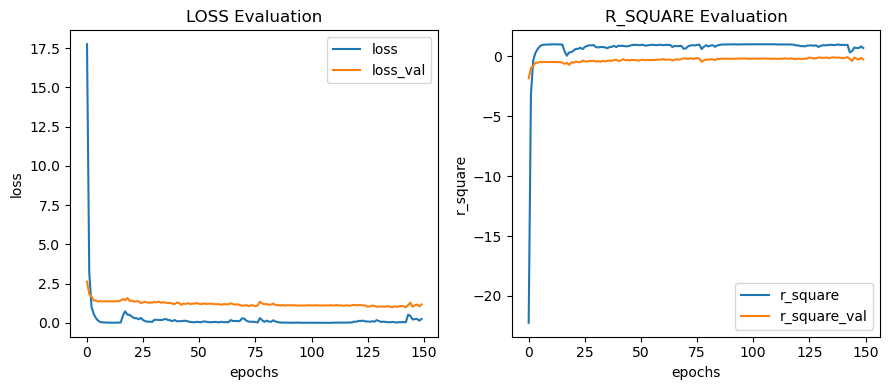

In [ ]:
set_seed(seed)

m1 = build_and_compile_model(
    "Model_1", 
    n_features=n_input, 
    addl_hidden=0, 
    activation='relu'
    )
    
m1_hist = m1.fit(
    np.array(X_model_train),
    y_train,
    epochs=150,
    batch_size=32,
    validation_data=(X_model_val, y_val),
    verbose=False,
    callbacks=early_stopping
)

plot_nn_curves(m1_hist)
print(model_evaluation(m1))

#### Model 1 validation results
* Loss: #####################
* R<sup>2</sup>: -#####################
* We have a negative result again, indicating the model is entirely unsuited for this problem.
* Based on the training and validation loss, the model is extremely overfit.
* Perhaps with how complex the NLP problem is, this neural network wasn't complex enough to find a relationship between predictors and target.
___

### Model 2
Changes: Add one hidden layer where nodes = 2/3 the nodes of previous layer

In [ ]:
set_seed(seed)

m2 = build_and_compile_model(
    "Model_2",
    n_features=n_input,
    addl_hidden=1,
    activation='relu'
)

m2_hist = m2.fit(
    np.array(X_model_train),
    y_train,
    epochs=150,
    batch_size=32,
    validation_data=(X_model_val, y_val),
    verbose=False,
    callbacks=early_stopping
)

plot_nn_curves(m2_hist)
print(model_evaluation(m2))

#### Model 2 validation results
* Loss: #####################
* R<sup>2</sup>: #####################
* R<sup>2</sup> is now positive, but it's still very low.
* Overfitting is still a problem.
___

### Model 3
Changes: Add one hidden layer where nodes = 2/3 the nodes of previous layer

In [ ]:
set_seed(seed)

m3 = build_and_compile_model(
    "Model_3",
    n_features=n_input,
    addl_hidden=2,
    activation='relu'
)

m3_hist = m3.fit(
    np.array(X_model_train),
    y_train,
    epochs=150,
    batch_size=32,
    validation_data=(X_model_val, y_val),
    verbose=False,
    callbacks=early_stopping
)

plot_nn_curves(m3_hist)
print(model_evaluation(m3))

#### Model 3 validation results
* Loss: #####################
* R<sup>2</sup>: #####################
* Performance is creeping up but still low.
___

### Model 4
Changes: Add one hidden layer where nodes = 2/3 the nodes of previous layer

In [ ]:
set_seed(seed)

m4 = build_and_compile_model(
    "Model_4",
    n_features=n_input,
    addl_hidden=3,
    activation='relu'
)

m4_hist = m4.fit(
    np.array(X_model_train),
    y_train,
    epochs=150,
    batch_size=32,
    validation_data=(X_model_val, y_val),
    verbose=False,
    callbacks=early_stopping
)

plot_nn_curves(m4_hist)
print(model_evaluation(m4))

#### Model 4 validation results
* Loss: #####################
* R<sup>2</sup>: #####################
* Performance declined!
___

### Model 5
Changes: Go back to model 3 and change activation from ReLU to ELU.

In [ ]:
set_seed(seed)

m5 = build_and_compile_model(
    "Model_5",
    n_features=n_input,
    addl_hidden=2,
    activation='elu'
)

m5_hist = m5.fit(
    np.array(X_model_train),
    y_train,
    epochs=150,
    batch_size=32,
    validation_data=(X_model_val, y_val),
    verbose=False,
    callbacks=early_stopping
)

plot_nn_curves(m5_hist)
print(model_evaluation(m5))

#### Model 5 validation results
* Loss: #####################
* R<sup>2</sup>: #####################
* Changing the activation to ELU greatly improved performance.
___

In [ ]:
time_check()

### Model 6
Changes: Add one hidden layer where nodes = 2/3 the nodes of previous layer.

In [ ]:
set_seed(seed)

m6 = build_and_compile_model(
    "Model_6",
    n_features=n_input,
    addl_hidden=3,
    activation='elu'
)

m6_hist = m6.fit(
    np.array(X_model_train),
    y_train,
    epochs=150,
    batch_size=32,
    validation_data=(X_model_val, y_val),
    verbose=False,
    callbacks=early_stopping
)

plot_nn_curves(m6_hist)
print(model_evaluation(m6))

#### Model 6 validation results
* Loss: #####################
* R<sup>2</sup>: #####################
* Performance improved but only slightly
___

### Model 7
Changes: Add one hidden layer where nodes = 2/3 the nodes of previous layer.

In [ ]:
set_seed(seed)

m7 = build_and_compile_model(
    "Model_7",
    n_features=n_input,
    addl_hidden=4,
    activation='elu'
)

m7_hist = m7.fit(
    np.array(X_model_train),
    y_train,
    epochs=150,
    batch_size=32,
    validation_data=(X_model_val, y_val),
    verbose=False,
    callbacks=early_stopping
)

plot_nn_curves(m7_hist)
print(model_evaluation(m7))

#### Model 7 validation results
* Loss: #####################
* R<sup>2</sup>: #####################
* Performance improved again; slightly more than last time.
___

### Model 8
Changes: Add one hidden layer where nodes = 2/3 the nodes of previous layer.

In [ ]:
set_seed(seed)

m8 = build_and_compile_model(
    "Model_8",
    n_features=n_input,
    addl_hidden=5,
    activation='elu'
)

m8_hist = m8.fit(
    np.array(X_model_train),
    y_train,
    epochs=150,
    batch_size=32,
    validation_data=(X_model_val, y_val),
    verbose=False,
    callbacks=early_stopping
)

plot_nn_curves(m8_hist)
print(model_evaluation(m8))

#### Model 8 validation results
* Loss: #####################
* R<sup>2</sup>: #####################
* Performance declined.
___

### Model 9
Changes: Go back to model 7 and change batch size from 32 to 16.

In [ ]:
set_seed(seed)

m9 = build_and_compile_model(
    "Model_9",
    n_features=n_input,
    addl_hidden=4,
    activation='elu'
)

m9_hist = m9.fit(
    np.array(X_model_train),
    y_train,
    epochs=150,
    batch_size=16,
    validation_data=(X_model_val, y_val),
    verbose=False,
    callbacks=early_stopping
)

plot_nn_curves(m9_hist)
print(model_evaluation(m9))

#### Model 9 validation results
* Loss: #####################
* R<sup>2</sup>: #####################
* Performance better than Model 8 but not Model 7.
___

### Model 10
Changes: Go back to Model 7 and add L1 regularization of 0.01.

In [ ]:
set_seed(seed)

m10 = build_and_compile_model(
    "Model_10",
    n_features=n_input,
    addl_hidden=4,
    activation='elu',
    l1_l2=(0.01, 0)
)

m10_hist = m10.fit(
    np.array(X_model_train),
    y_train,
    epochs=150,
    batch_size=32,
    validation_data=(X_model_val, y_val),
    verbose=False,
    callbacks=early_stopping
)

plot_nn_curves(m10_hist)
print(model_evaluation(m10))

#### Model 10 validation results
* Loss: #####################
* R<sup>2</sup>: #####################
* Overfitting is less of an issue, but performance took a hit.
___

### Model 11
Changes: Go back to Model 7 and add L2 regularization of 0.01.

In [ ]:
set_seed(seed)

m11 = build_and_compile_model(
    "Model_11",
    n_features=n_input,
    addl_hidden=4,
    activation='elu',
    l1_l2=(0, 0.01),
)

m11_hist = m11.fit(
    np.array(X_model_train),
    y_train,
    epochs=150,
    batch_size=32,
    validation_data=(X_model_val, y_val),
    verbose=False,
    callbacks=early_stopping
)

plot_nn_curves(m11_hist)
print(model_evaluation(m11))

#### Model 11 validation results
* Loss: #####################
* R<sup>2</sup>: #####################
* Overfitting is less of an issue, but performance took a hit.
___

### Model 12
Changes: Go back to Model 7 and add L1 regularization of 0.05.

In [ ]:
set_seed(seed)

m12 = build_and_compile_model(
    "Model_12",
    n_features=n_input,
    addl_hidden=4,
    activation='elu',
    l1_l2=(0.05, 0)
)

m12_hist = m12.fit(
    np.array(X_model_train),
    y_train,
    epochs=150,
    batch_size=32,
    validation_data=(X_model_val, y_val),
    verbose=False,
    callbacks=early_stopping
)

plot_nn_curves(m12_hist)
print(model_evaluation(m12))

#### Model 12 validation results
* Loss: #####################
* R<sup>2</sup>: #####################
* Performance is close to Model 7 and overfitting is more under control.
___

### Model 13
Changes: Go back to Model 7 and add L2 regularization of 0.05.

In [ ]:
set_seed(seed)

m13 = build_and_compile_model(
    "Model_13",
    n_features=n_input,
    addl_hidden=4,
    activation='elu',
    l1_l2=(0, 0.05)
)

m13_hist = m13.fit(
    np.array(X_model_train),
    y_train,
    epochs=150,
    batch_size=32,
    validation_data=(X_model_val, y_val),
    verbose=False,
    callbacks=early_stopping
)

plot_nn_curves(m13_hist)
print(model_evaluation(m13))

#### Model 13 validation results
* Loss: #####################
* R<sup>2</sup>: #####################
* Not as good as the L1(0.05) model (Model 12).
___

### Model 14
Changes: Go back to Model 12 and add Dropout regularization of 0.1.

In [ ]:
set_seed(seed)

m14 = build_and_compile_model(
    "Model_14",
    n_features=n_input,
    addl_hidden=4,
    activation='elu',
    l1_l2=(0.05, 0),
    dropout_factor=0.1
)

m14_hist = m14.fit(
    np.array(X_model_train),
    y_train,
    epochs=150,
    batch_size=32,
    validation_data=(X_model_val, y_val),
    verbose=False,
    callbacks=early_stopping
)

plot_nn_curves(m14_hist)
print(model_evaluation(m14))

#### Model 14 validation results
* Loss: #####################
* R<sup>2</sup>: #####################
* Dropout reduced overfitting greatly, but performance declined way too much.
___

### Model 15
Changes: Go back to Model 12 and add another hidden layer where nodes = 2/3 the nodes of previous layer.

In [ ]:
set_seed(seed)

m15 = build_and_compile_model(
    "Model_15",
    n_features=n_input,
    addl_hidden=5,
    activation='elu',
    l1_l2=(0.05, 0)
)

m15_hist = m15.fit(
    np.array(X_model_train),
    y_train,
    epochs=150,
    batch_size=32,
    validation_data=(X_model_val, y_val),
    verbose=False,
    callbacks=early_stopping
)

plot_nn_curves(m15_hist)
print(model_evaluation(m15))

#### Model 15 validation results
* Loss: #####################
* R<sup>2</sup>: #####################
* Adding another layer made the model perform marginally worse.
___

### Final Model Evaluation

Models 7 and 12 had the lowest loss and highest R-squared when tested on the validation set.

Although Model 7 had a higher validation score, I am going with Model 12 as it addresses **overfitting** and probably generalizes better to unseen data.

Finally, it's time to see how the model performs on the **test set**.

In [ ]:
# REDO ITERATIVE PROCESS BUT WITH LAYER=1/2!!!
final_model = m12
final_model._name = "Final Model"
print(model_evaluation(final_model, pred_test=X_model_test, target_test=y_test, val_or_test="Test"))

In [ ]:
# Total time:
time_check()

#### Here's what these results mean about the final model.
????????????????????
* **Loss (Mean Squared Error):**
* **Performance (R-squared):**

????????????????????

## Conclusion 


### Recommendations
<!-- * Because false negatives are still an issue, reporters should still look at all tweets, but can also be given the model's probability that a tweet is about a disaster.
* Discard search terms that don't yield many disaster tweets, such as "harm," "bloody," "screaming," "ruin," etc.
* Narrow the criteria for what constitutes a "disaster." This dataset sometimes puts the "disaster" label on long-term crises like droughts, and past disasters like the hiroshima bombing. Perhaps the *The Flatiron Post* should focus on so-called "kinetic events" and more unpredictable crises (bombings, earthquakes, crashes, etc.). This would require either relabeling the dataset or gathering new data. -->

### Limitations and Future Work

<!-- * The training of this model is limited by the tweets provided, as well as the search terms that were used to obtain them. Searching for things like "explosion," "fire," "suicide bomber," etc. seems like it should yield tweets about disasters. But there may be other tweets without blatant keywords. Having access to a less biased sample of tweets might yield better results.
* The tweets in the provided dataset show if a tweet originally contained a URL, but not if it contained a picture or video. Having that as a feature might have improved the model's performance.
* The purpose of this model is to provide *The Flatiron Post* with a feed-like tool that shows tweets related to disasters and crises. This model is just one piece of the pipeline. Other pieces include a tool that automatically requests tweets through Twitter's API, as well as a user-friendly interface. -->